In [1]:
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [1]:
# # Load the store sales dataset
# excel_file = pd.ExcelFile('data/store_sales.xlsx')
# sheet_names = excel_file.sheet_names

# # Read the data
# results_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = results_df['IRI_KEY'].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# features = ['F', 'D', 'Unit.Price']
# target = 'Total.Volume'

# results_df = results_df[results_df['IRI_KEY'] == iri_keys[0]]
# X = results_df[features].values
# y = results_df[target].values

# sheet_names, iri_keys, X.shape, y.shape

In [3]:
# # Load the Boston dataset
# data_url = 'http://lib.stat.cmu.edu/datasets/boston'
# raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22,  # type: ignore
#                      header=None)  # type: ignore
# X = np.hstack([raw_df.values[::2, :-1], raw_df.values[1::2, :2]])
# y = raw_df.values[1::2, 2].reshape(-1, 1).ravel()
# X.shape, y.shape

In [4]:
# Load the California housing dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X = housing.data  # type: ignore
y = housing.target  # type: ignore
X.shape, y.shape, housing.feature_names[0:6]  # type: ignore

((20640, 8),
 (20640,),
 ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'])

In [5]:
# # Load the soybean dataset
# raw_df = pd.read_excel("data/soybean.xlsx")
# # print(raw_df.head())
# X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
#                       34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]] # 9, 12
# y = raw_df.values[:-1, 11]
# X.shape, y.shape

In [6]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # type: ignore

In [7]:
from sklearn.model_selection import GridSearchCV
from models_sklearn import Ensemble, MLP, FONN1, FONN2, TREENN1, TREENN2
from models import MLP as MLP_2, FONN1 as FONN1_2, FONN2 as FONN2_2, TREENN1 as TREENN1_2, TREENN2 as TREENN2_2


grid_search_params = {
    'scoring': ['neg_root_mean_squared_error', 'r2'],
    'n_jobs': -1,
    'refit': 'neg_root_mean_squared_error',
    'verbose': 1,
    'return_train_score': True
}

ensemble_param_grid = {
}

mlp_param_grid = {
    # 'max_iter': [1000, 100, 2000],
    'max_iter': [1000],
    'learning_rate': ['constant'],
    # 'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [1e-1, 1e-2, 1e-3],
    # 'learning_rate_init': [1e1, 1e-2, 1e-3],
    # 'tol': [1e-4],
    'early_stopping': [True]
    # 'early_stopping': [True, False],
}

models = {}
models['Tree'] = GridSearchCV(
    Ensemble(1), ensemble_param_grid, **grid_search_params)
models['Ensemble 5'] = GridSearchCV(
    Ensemble(5), ensemble_param_grid, **grid_search_params)
models['MLP 5'] = GridSearchCV(MLP(5), mlp_param_grid, **grid_search_params)
# models['FONN1 5 5'] = GridSearchCV(
#     FONN1(5, (10,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 5'] = GridSearchCV(
#     FONN2(5, (10,)), mlp_param_grid, **grid_search_params)
models['TREENN1 5'] = GridSearchCV(
    TREENN1((6,)), mlp_param_grid, **grid_search_params)
models['TREENN2 5'] = GridSearchCV(
    TREENN2((6,)), mlp_param_grid, **grid_search_params)

# models['Ensemble 10'] = GridSearchCV(
#     Ensemble(10), ensemble_param_grid, **grid_search_params)
# models['MLP 10'] = GridSearchCV(
#     MLP(10), mlp_param_grid, **grid_search_params)
# models['FONN1 5 10'] = GridSearchCV(
#     FONN1(5, (10,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 10'] = GridSearchCV(
#     FONN2(5, (10,)), mlp_param_grid, **grid_search_params)
# models['TREENN1 10'] = GridSearchCV(
#     TREENN1((11,)), mlp_param_grid, **grid_search_params)
# models['TREENN2 10'] = GridSearchCV(
#     TREENN2((11,)), mlp_param_grid, **grid_search_params)

# models['Ensemble 40'] = GridSearchCV(
#     Ensemble(40), ensemble_param_grid, **grid_search_params)
# models['MLP 40'] = GridSearchCV(
#     MLP(40), mlp_param_grid, **grid_search_params)
# models['FONN1 5 40'] = GridSearchCV(
#     FONN1(5, (45,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 40'] = GridSearchCV(
#     FONN2(5, (45,)), mlp_param_grid, **grid_search_params)
# models['TREENN1 40'] = GridSearchCV(
#     TREENN1((41,)), mlp_param_grid, **grid_search_params)
# models['TREENN2 40'] = GridSearchCV(
#     TREENN2((41,)), mlp_param_grid, **grid_search_params)

# models['Ensemble 100'] = GridSearchCV(
#     Ensemble(100), ensemble_param_grid, **grid_search_params)
# models['MLP 100'] = GridSearchCV(
#     MLP(100), mlp_param_grid, **grid_search_params)
# models['FONN1 5 100'] = GridSearchCV(
#     FONN1(5, (105,)), mlp_param_grid, **grid_search_params)
# models['FONN2 5 100'] = GridSearchCV(
#     FONN2(5, (105,)), mlp_param_grid, **grid_search_params)
# models['TREENN1 100'] = GridSearchCV(
#     TREENN1((101,)), mlp_param_grid, **grid_search_params)
# models['TREENN2 100'] = GridSearchCV(
#     TREENN2((101,)), mlp_param_grid, **grid_search_params)

mlp_param_grid_2 = {
    'epochs': [4000, 1000],
    # 'learning_rate': [1e1, 1e0, 1e-1, 1e-2],
    'learning_rate': [1e-2, 1e-3],
}

# input_dim = X.shape[1]
# hidden_dim = 10
# output_dim = 1

# models['MLP_2 10'] = GridSearchCV(
#     MLP_2(input_dim, hidden_dim, output_dim), mlp_param_grid_2, **grid_search_params)

# num_trees_input = 5
# models['FONN1_2 5 10'] = GridSearchCV(
#     FONN1_2(input_dim, hidden_dim, output_dim, num_trees_input), mlp_param_grid_2, **grid_search_params)

# num_trees_hidden = 5
# models['FONN2_2 5 10'] = GridSearchCV(
#     FONN2_2(input_dim, hidden_dim, output_dim, num_trees_hidden), mlp_param_grid_2, **grid_search_params)

# # models['TREENN1_2 10'] = GridSearchCV(
# #     TREENN1_2(input_dim, hidden_dim, output_dim), mlp_param_grid_2, **grid_search_params)

# # models['TREENN2_2 10'] = GridSearchCV(
# #     TREENN2_2(input_dim, hidden_dim, output_dim), mlp_param_grid_2, **grid_search_params)
# models['TREENN1_2 10'] = GridSearchCV(
#     FONN1_2(input_dim, hidden_dim, output_dim, 1), mlp_param_grid_2, **grid_search_params)

# models['TREENN2_2 10'] = GridSearchCV(
#     FONN2_2(input_dim, hidden_dim, output_dim, 1), mlp_param_grid_2, **grid_search_params)

# models['Tree-based Predictions (FONN2)'] = models['FONN2'].trees
# models['Tree-based Predictions (TREENN2)'] = models['TREENN2'].trees

In [13]:
# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    'mean_fit_time', 'mean_score_time', 'mean_train_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'mean_train_r2', 'mean_test_r2', 'params'
]

for name, model in models.items():
    model.fit(X, y)
    result = model.cv_results_
    results.append({
        'model': name,
        **{col: result[col][model.best_index_] for col in result_columns if col in result}
    })
    cv_results[name] = result

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
results_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
Tree,0.333305,0.003293,-0.382423,-0.807371,0.853238,0.294812,{}
Ensemble 5,1.290441,0.009076,-0.220481,-0.624451,0.951209,0.577831,{}
MLP 5,1.347205,0.001464,-0.521292,-0.569797,0.727299,0.654244,"{'early_stopping': True, 'learning_rate': 'con..."
FONN1 5 5,3.580536,0.011215,-0.194271,-0.630827,0.962064,0.566333,"{'early_stopping': True, 'learning_rate': 'con..."
FONN2 5 5,5.204237,0.001475,-0.695536,-0.710618,0.514284,0.457853,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN1 5,1.522284,0.002987,-0.345237,-0.656288,0.880386,0.536049,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN2 5,1.807345,0.001599,-0.603562,-0.660350,0.632135,0.529526,"{'early_stopping': True, 'learning_rate': 'con..."


In [14]:
results_df.sort_values(by='mean_test_neg_root_mean_squared_error', ascending=False)

,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
MLP 5,1.347205,0.001464,-0.521292,-0.569797,0.727299,0.654244,"{'early_stopping': True, 'learning_rate': 'con..."
Ensemble 5,1.290441,0.009076,-0.220481,-0.624451,0.951209,0.577831,{}
FONN1 5 5,3.580536,0.011215,-0.194271,-0.630827,0.962064,0.566333,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN1 5,1.522284,0.002987,-0.345237,-0.656288,0.880386,0.536049,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN2 5,1.807345,0.001599,-0.603562,-0.660350,0.632135,0.529526,"{'early_stopping': True, 'learning_rate': 'con..."
FONN2 5 5,5.204237,0.001475,-0.695536,-0.710618,0.514284,0.457853,"{'early_stopping': True, 'learning_rate': 'con..."
Tree,0.333305,0.003293,-0.382423,-0.807371,0.853238,0.294812,{}


In [15]:
[(result['model'], result['params']) for result in results], cv_results

([('Tree', {}),
  ('Ensemble 5', {}),
  ('MLP 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000}),
  ('FONN1 5 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000}),
  ('FONN2 5 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'max_iter': 1000}),
  ('TREENN1 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000}),
  ('TREENN2 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000})],
 {'Tree': {'mean_fit_time': array([0.33330545]),
   'std_fit_time': array([0.01036138]),
   'mean_score_time': array([0.00329347]),
   'std_score_time': array([0.00026771]),
   'params': [{}],
   'split0_test_neg_root_mean_squared_error': array([-0.87465685]),
   'split1_test_neg_root_mean_squared_

In [18]:
dataset_rank = results_df[['mean_test_neg_root_mean_squared_error']].rank(numeric_only=True, ascending=False)
dataset_rank = dataset_rank.assign(Mean=dataset_rank.mean(1), Stddev=dataset_rank.std(1))
dataset_rank

,mean_test_neg_root_mean_squared_error,Mean,Stddev
model,,,
Tree,7.0,7.0,NaN
Ensemble 5,2.0,2.0,NaN
MLP 5,1.0,1.0,NaN
FONN1 5 5,3.0,3.0,NaN
FONN2 5 5,6.0,6.0,NaN
TREENN1 5,4.0,4.0,NaN
TREENN2 5,5.0,5.0,NaN


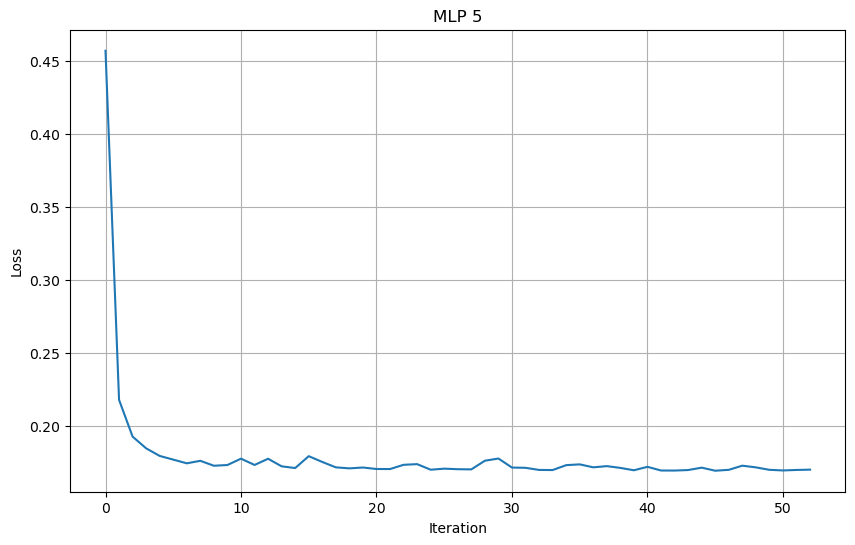

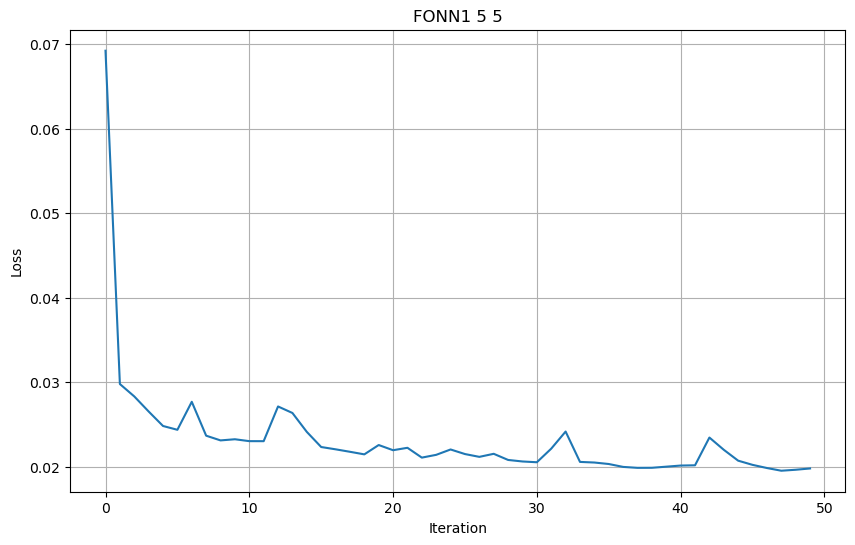

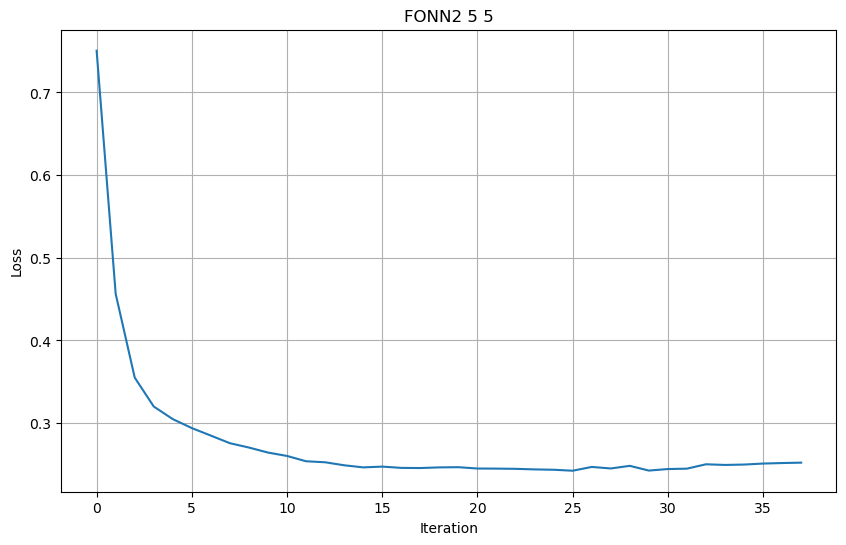

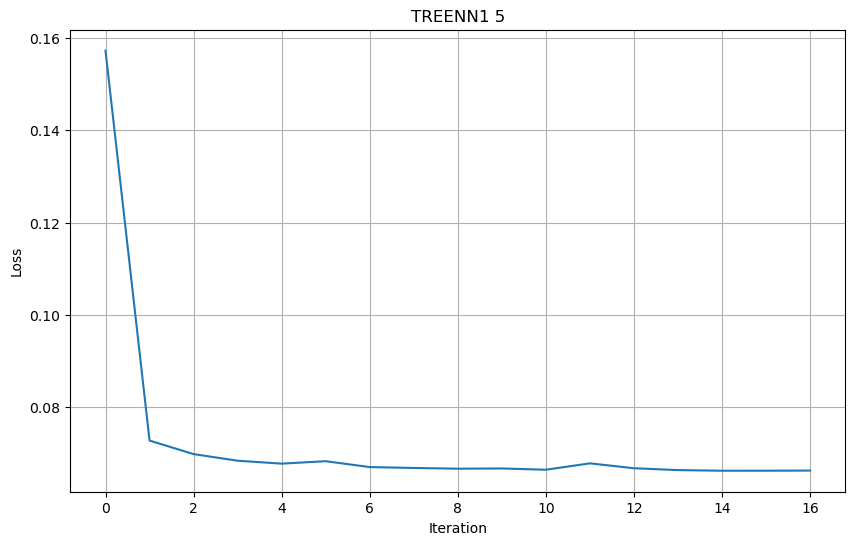

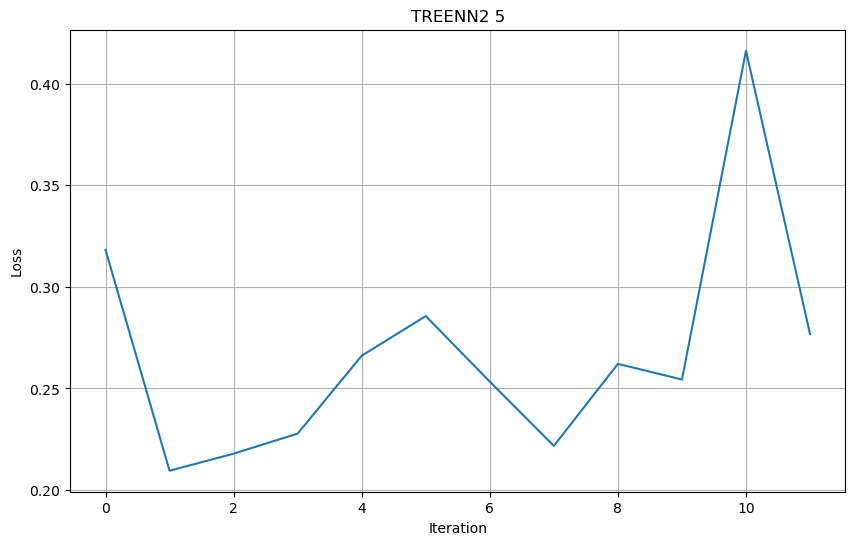

In [19]:
import matplotlib.pyplot as plt


def plot_loss(model, title='Loss Curve'):
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_curve_)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid()
    plt.show()

for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        plot_loss(model.best_estimator_, model_name)